In [120]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os
from sklearn.feature_selection import SelectKBest
import pymssql
from tqdm import tqdm
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.11.0


In [83]:
conn = pymssql.connect(server='localhost', user='sa', password='Passw0rd!', database='Loans_2023_01_27')
cursor = conn.cursor()

def get_column_index(cursor, column_name):
    for index, col in enumerate(cursor.description):
        if col[0] == column_name:
            return index

additional_data_headers = ["RentMortgagePayment" ,"TotalIncome" ,"RentMortgage" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles"]
additional_data_sql = "VIN,"
for i, header in enumerate(additional_data_headers):
    additional_data_sql += header
    if i!=len(additional_data_headers)-1:
        additional_data_sql+=','

headers = []
rows = []

# Underwriting Data
cursor.execute("SELECT * FROM dbo.UnderwritingData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "VIN")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        row[vin_index] = row[vin_index][-6:]
        rows.append(row)
    res = cursor.fetchone()

df = pd.DataFrame(rows, columns=headers)


#Additional Data
cursor.execute("Select {vCols} FROM dbo.VerificationsDec".format(vCols = additional_data_sql))

addl_data_rows = []
res = cursor.fetchone()

while res:
    row = [element for element in res]
    row[0] = row[0].strip()[-6:]
    addl_data_rows.append(row)
    res = cursor.fetchone()

print("Assigning Additional Entities")
for data in tqdm(addl_data_rows):
    df.loc[df['VIN']==data[0], additional_data_headers] = data[1:]

#Results from RawAlgorithmData
cursor.execute("SELECT Vin6,ProcStatsCd FROM dbo.RawAlgorithmData")
res = cursor.fetchone()
loan_results = dict()
while res:
    vin6 = res[0].strip()[-6:]
    loan_results[vin6] = res[1].strip()
    res = cursor.fetchone()

default_result = ["NA" for i in range(len(df))]
df['Result'] = default_result

print("Assigning Results")
for vin6, res in tqdm(loan_results.items()):
    df.loc[df['VIN'] == vin6, 'Result'] = res

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "Result"]]

df = df[(df['Result']=='CO') | (df['Result']=='CL')]
df['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
df['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
df.fillna(df.mean())

Assigning Additional Entities


100%|██████████| 28023/28023 [00:31<00:00, 891.78it/s]


Assigning Results


100%|██████████| 24961/24961 [00:17<00:00, 1396.58it/s]


,RentMortgagePayment,TotalIncome,CarPayment,Expenses,AvailableIncome,Miles,OpeningBalance,Salary,Term,VehicleYear,...,LatePaymentHistory001260,LatePaymentHistory001290Plus,PaidAccounts,InquiriesLast6Months,OpenTotalInBadStatus,CurrentPaymentsMade,RentMortgage,CashDown,HomeOwner,Result
0,0.0,9026.33,418.370000,1405.150000,7621.18,79970.0,13048.40,4604.0,48,2006,...,0,0,3,10,1,316,0.000000,3000,0,1
1,0.0,1800.00,353.516981,479.690000,-278.60,81332.0,10713.00,4080.0,48,2009,...,0,0,0,4,3,0,86.041617,1500,0,1
2,0.0,2000.00,379.480000,716.603493,1620.52,12647.0,11835.77,3400.0,48,2015,...,0,0,1,4,9,0,0.000000,2000,0,1
3,0.0,2400.00,394.980000,613.760000,1786.24,95607.0,14767.22,2400.0,42,2009,...,0,0,5,8,0,20,0.000000,0,0,0
4,450.0,4370.00,388.490000,938.490000,3431.51,125364.0,14975.10,4374.0,40,2007,...,0,0,0,4,20,3,450.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17361,400.0,2400.00,322.650000,979.760000,1420.24,77987.0,12457.88,2500.0,44,2013,...,1,0,2,3,3,19,400.000000,1150,0,1
17536,0.0,2400.00,326.960000,423.640000,1976.36,108628.0,6429.00,2500.0,24,2011,...,0,0,0,0,0,0,0.000000,2500,0,1
17560,250.0,5000.00,418.820000,859.820000,4140.18,122128.0,10442.00,2300.0,44,2014,...,2,11,0,0,0,0,250.000000,1250,0,0
17588,0.0,3000.00,382.810000,1607.510000,1392.49,105835.0,14101.00,4492.0,48,2018,...,0,0,0,0,0,0,0.000000,2000,0,1


In [196]:
dfsmall = df[["CreaditScore", "InquiresTotal","Expenses","CashDown","CurrentPaymentsMade", "Result"]]

x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2)
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

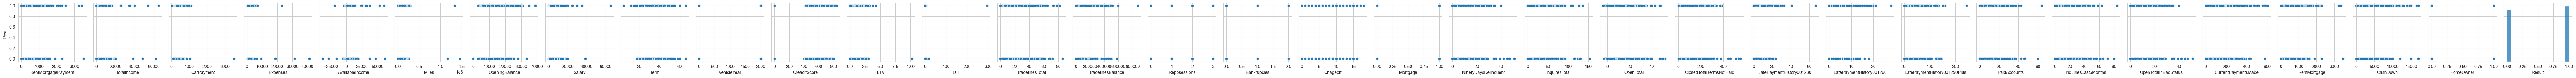

In [197]:
# fig, axes = plt.subplots(ncols=3)
# for i, yvar in enumerate(df.columns):
#     axes[i].scatter(df['Result'],df[yvar])

pp = sns.pairplot(data=df,
                  y_vars=["Result"],
                  x_vars=df.columns)

In [198]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

In [199]:
def log_loss(y_predd, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_predd)
  return tf.reduce_mean(ce)

In [200]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [201]:
log_reg = LogisticRegression()

In [202]:
y_pred = log_reg(x_train_norm[:5], train=False)
print(y_pred.numpy())

[1.4502103e-02 3.2821763e-04 2.6195475e-01 9.9999738e-01 3.3791894e-01]


In [203]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [204]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [205]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  last_x_batch = []
  last_y_batch = []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      length = len(y_pred_batch)
      batch_loss = log_loss(y_pred_batch.reshape((length,1)), y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    last_x_batch = x_batch
    last_y_batch = y_batch
    y_pred_batch = log_reg(x_batch)
    length = len(y_pred_batch)
    batch_loss = log_loss(y_pred_batch.reshape((length,1)), y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")
    # ypred = log_reg(last_x_batch, train = False)
    # print(ypred)
    # print(predict_class(ypred))
    # print(last_y_batch.reshape((14,)))

Epoch: 0, Training log loss: 1.929
Epoch: 20, Training log loss: 0.675
Epoch: 40, Training log loss: 0.668
Epoch: 60, Training log loss: 0.666
Epoch: 80, Training log loss: 0.666
Epoch: 100, Training log loss: 0.666
Epoch: 120, Training log loss: 0.665
Epoch: 140, Training log loss: 0.665
Epoch: 160, Training log loss: 0.665
Epoch: 180, Training log loss: 0.665


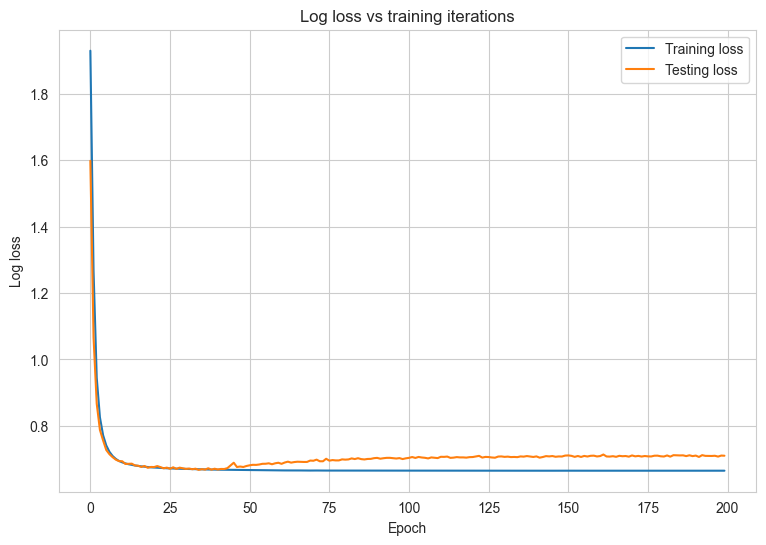

In [206]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

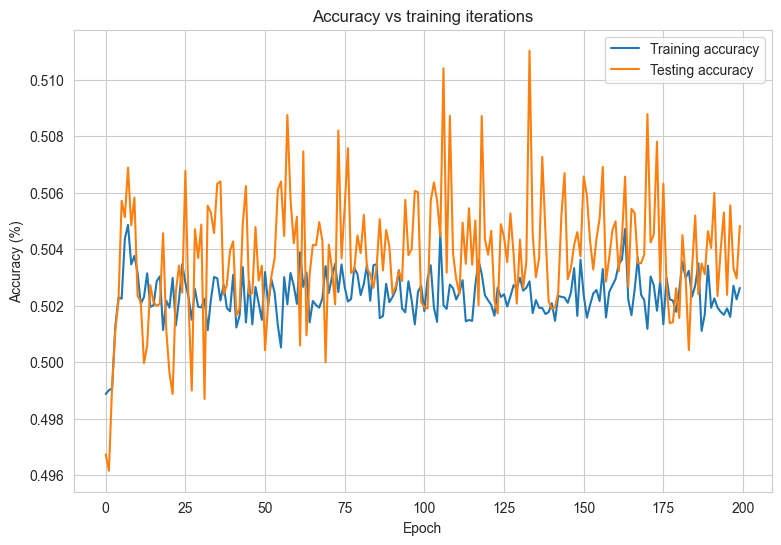

In [207]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [208]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.665
Final testing log Loss: 0.710


In [209]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.503
Final testing accuracy: 0.505


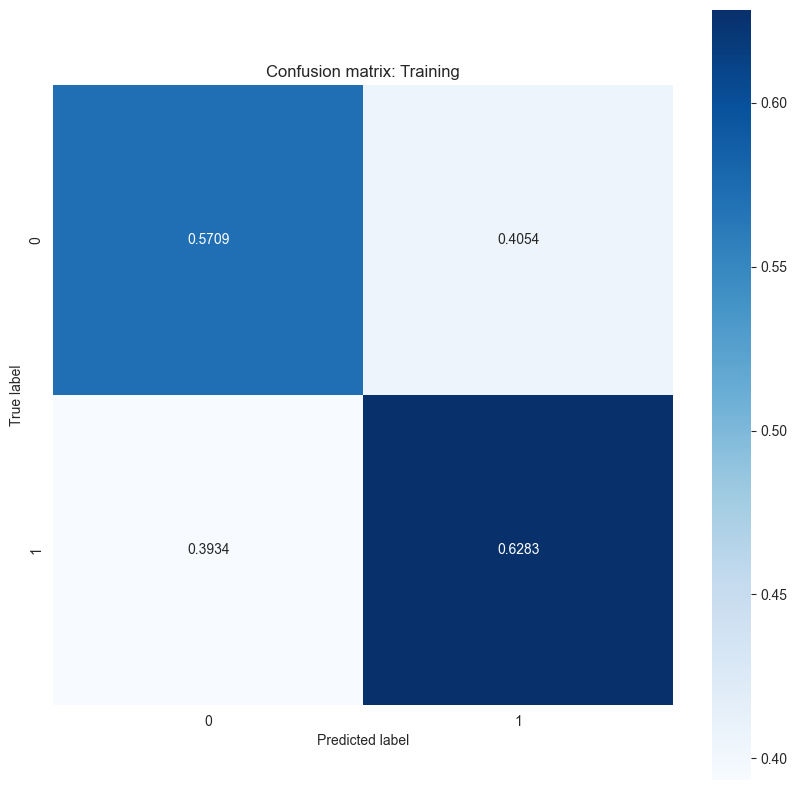

In [210]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)
show_confusion_matrix(y_train, train_classes, 'Training')

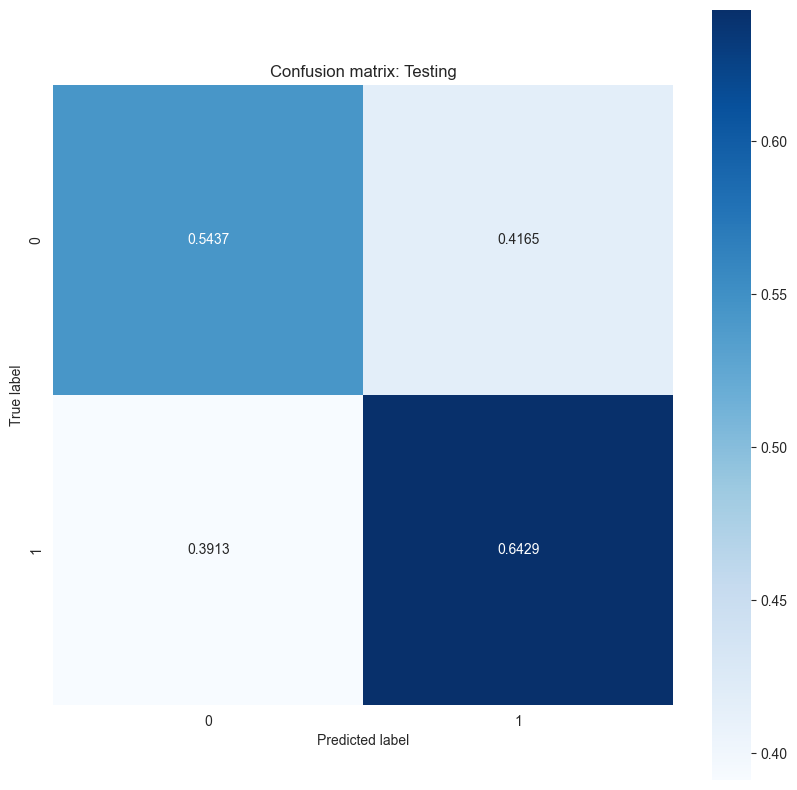

In [211]:
show_confusion_matrix(y_test, test_classes, 'Testing')